In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('0005.hk','2018-01-01','2022-04-09')

[*********************100%***********************]  1 of 1 completed


In [3]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2022-03-30,53.799999,54.450001,53.750000,53.950001,53.950001,20820331,53.308334,52.045834,69.919360,-20.833320,-10.638296,1.600002,4.350002,52.545739,52.523670,0.022069,0.950001,46.622377,18.475039,54.200001
2022-03-31,53.950001,54.299999,53.799999,54.200001,54.200001,12951991,53.483334,52.462500,71.849555,-14.285714,-6.849312,1.049999,5.000000,52.800241,52.647843,0.152398,0.500000,50.893767,20.961286,54.349998
2022-04-01,53.700001,54.349998,53.400002,54.349998,54.349998,8177523,53.758333,52.891667,73.059622,-6.060739,-2.777840,1.649998,5.149998,53.038665,52.773929,0.264737,0.949997,53.568896,22.508117,54.049999
2022-04-04,54.299999,54.349998,53.799999,54.049999,54.049999,10779509,53.966667,53.129167,66.399654,-24.242494,-12.903266,1.250000,2.849998,53.194255,52.868452,0.325803,0.549999,35.812143,17.491249,53.700001
2022-04-06,53.900002,54.049999,53.150002,53.700001,53.700001,17097274,53.958333,53.320833,59.070435,-57.692342,-31.249980,-0.049999,2.299999,53.272062,52.930049,0.342013,0.899998,16.890204,11.670984,53.450001


In [5]:
sc = MinMaxScaler(feature_range = (-1, 1))
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_63907/543750826.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


/opt/homebrew/Caskroom/miniforge/base/envs/fyp_new/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


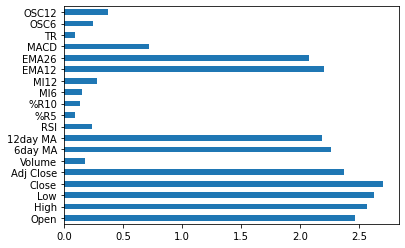

In [6]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.show()

In [7]:
# X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(734, 1, 19) (734, 1) (184, 1, 19) (184, 1)


In [8]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-12 22:27:02.629634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-12 22:27:02.629752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/500


2022-04-12 22:27:03.065177: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-12 22:27:04.398951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:27:04.631009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:27:04.668860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:27:04.746944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:27:04.825206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 3s 26ms/step - loss: 3617.9751 - val_loss: 1590.0951
Epoch 2/500
 1/42 [..............................] - ETA: 0s - loss: 5017.6353

2022-04-12 22:27:05.793643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:27:05.874001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:27:05.899161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 0s 11ms/step - loss: 2323.9353 - val_loss: 1491.2068
Epoch 3/500
42/42 [==============================] - 0s 10ms/step - loss: 248.1573 - val_loss: 862.8173
Epoch 4/500
42/42 [==============================] - 0s 11ms/step - loss: 69.4241 - val_loss: 255.3400
Epoch 5/500
42/42 [==============================] - 0s 11ms/step - loss: 32.6675 - val_loss: 104.2622
Epoch 6/500
42/42 [==============================] - 0s 11ms/step - loss: 32.1794 - val_loss: 98.8935
Epoch 7/500
42/42 [==============================] - 0s 11ms/step - loss: 26.1911 - val_loss: 92.4985
Epoch 8/500
42/42 [==============================] - 0s 11ms/step - loss: 23.6548 - val_loss: 90.2214
Epoch 9/500
42/42 [==============================] - 0s 11ms/step - loss: 21.4062 - val_loss: 88.3058
Epoch 10/500
42/42 [==============================] - 0s 11ms/step - loss: 19.3565 - val_loss: 85.6115
Epoch 11/500
42/42 [==============================] - 1s 13ms/step - loss: 17.5900 - 

Epoch 83/500
42/42 [==============================] - 0s 9ms/step - loss: 1.8794 - val_loss: 4.0223
Epoch 84/500
42/42 [==============================] - 0s 9ms/step - loss: 1.8649 - val_loss: 3.9130
Epoch 85/500
42/42 [==============================] - 0s 9ms/step - loss: 1.8522 - val_loss: 3.8054
Epoch 86/500
42/42 [==============================] - 0s 10ms/step - loss: 1.8414 - val_loss: 3.6999
Epoch 87/500
42/42 [==============================] - 0s 10ms/step - loss: 1.8321 - val_loss: 3.5968
Epoch 88/500
42/42 [==============================] - 0s 9ms/step - loss: 1.8244 - val_loss: 3.4966
Epoch 89/500
42/42 [==============================] - 0s 9ms/step - loss: 1.8180 - val_loss: 3.3994
Epoch 90/500
42/42 [==============================] - 0s 9ms/step - loss: 1.8129 - val_loss: 3.3054
Epoch 91/500
42/42 [==============================] - 0s 9ms/step - loss: 1.8088 - val_loss: 3.2149
Epoch 92/500
42/42 [==============================] - 0s 9ms/step - loss: 1.8057 - val_loss: 3.127

42/42 [==============================] - 0s 10ms/step - loss: 1.9101 - val_loss: 1.2793
Epoch 165/500
42/42 [==============================] - 0s 10ms/step - loss: 2.6580 - val_loss: 1.3697
Epoch 166/500
42/42 [==============================] - 0s 10ms/step - loss: 3.7279 - val_loss: 3.6565
Epoch 167/500
42/42 [==============================] - 0s 9ms/step - loss: 3.9789 - val_loss: 7.3594
Epoch 168/500
42/42 [==============================] - 0s 9ms/step - loss: 2.6478 - val_loss: 5.5316
Epoch 169/500
42/42 [==============================] - 0s 10ms/step - loss: 4.6237 - val_loss: 4.1417
Epoch 170/500
42/42 [==============================] - 0s 9ms/step - loss: 6.7091 - val_loss: 11.4270
Epoch 171/500
42/42 [==============================] - 0s 10ms/step - loss: 2.8043 - val_loss: 1.9275
Epoch 172/500
42/42 [==============================] - 0s 9ms/step - loss: 14.6305 - val_loss: 9.1027
Epoch 173/500
42/42 [==============================] - 0s 9ms/step - loss: 14.4882 - val_loss: 4.3

2022-04-12 22:28:29.067497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:28:29.138884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-12 22:28:29.166027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


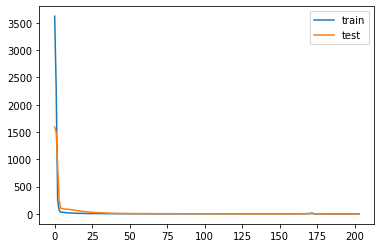

In [10]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

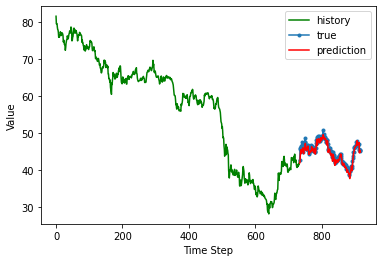

In [11]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

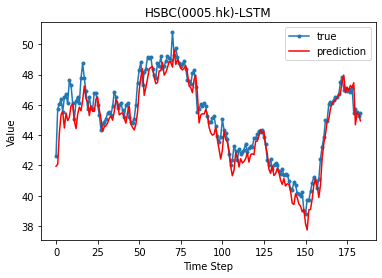

In [12]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.title('HSBC(0005.hk)-LSTM')
plt.legend()
plt.show();

In [13]:
r2_score(y_test,y_pred)

0.8828570818094693

In [14]:
mean_absolute_percentage_error(y_test,y_pred)

0.015067381560982158

In [15]:
mean_squared_error(y_test,y_pred,squared=False)

0.9005453755205812

In [16]:
x_val=data_val.drop(['Prediction'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_63907/2648236666.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction'],1)


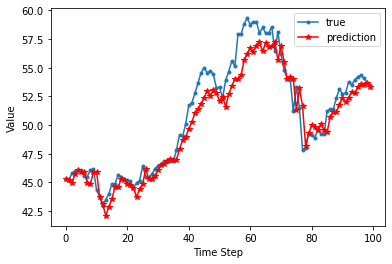

In [17]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [18]:
r2_score(y_val,y_val_pred)

0.9086903777887116

In [19]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.020417391112054692

In [20]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

1.4264689254058232